<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Classes" data-toc-modified-id="Neural-Network-Classes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Classes</a></span></li><li><span><a href="#Additional-Required-Functions" data-toc-modified-id="Additional-Required-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Additional Required Functions</a></span></li><li><span><a href="#Application-to-Three-Data-Sets" data-toc-modified-id="Application-to-Three-Data-Sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Application to Three Data Sets</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=10>Neural Networks in Pytorch</font>

SURAJ ESWARAN

In this assignment, you will
1. complete the implementations of neural network classes,
2. define the new function `multiple_runs_classification`,
3. define the new function `multiple_runs_convolutional`,
4. copy and paste `percent_correct` and `confusion_matrx` from previous notes,
4. present and discuss regression results on automobile MPG data,
5. present and discuss classification results on diabetes data,
6. present and discuss classification results on small version of MNIST data.

# Neural Network Classes

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time

In [139]:
torch.__version__

'1.7.0'

For this assignment, start with implementations of the following classes:
* `NeuralNetworkTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierConvolutionalTorch`: copied and pasted from Lecture Notes 16.1 and completed.

The `train` functions in this classes have two additional arguments, `Xval`nad `Tval`:

```python
   def train(self, Xtrain, Ttrain, n_epochs, learning_rate=0.01, method='adam', verbose=True, 
             Xval=None, Tval=None):
```

where `Xtrain` and `Ttrain` are the usual two arguments used to train the network, and `Xval` and `Tval` are the validation data matrices.  `Xval` and `Tval` are only used to calculate the performance (MSE or NLL) once per epoch.  If the performance is better than the best so far, update an array that is storing the best weight values so far, and also update the best performance so far.  When training is complete, copy the stored best-so-far weights back into the network.  If `Xval` is `None`, then this step is ignored and the weights in the neural network at the end of training are not modified.

# NeuralNetworkTorch
First, here is an implementation of NeuralNetworkTorch.

In [163]:
######################################################################
## NeuralNetwork  for regression
######################################################################

class NeuralNetworkTorch(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        super().__init__()

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.device = device

        self.n_layers = len(n_hiddens_list) + 1 #Record the number of layers
        
        #Build up the list of layers
        self.layers = torch.nn.ModuleList() #List of module list
        for n_units in n_hiddens_list:
            #n_unit in n_hidden_list -> List of number of units in each hidden layer
            self.layers.append(self._make_tanh_layer(n_inputs, n_units)) #append to add an another module to it
            n_inputs = n_units #It updates this little local variable number of inputs to be number of units which becomes the number of inputs for the next layer. 
        self.layers.append(torch.nn.Linear(n_inputs, n_outputs)) #Append the linear layer for the output layer wihtout hyperbolic tangent  

        #As we have done for the Numpy class, we are going to initialize some standardization parameters to be. 
        self.stand_params = None #None are error trace to be empty
        self.error_trace = []
        self.error_trace_val = []

    def _make_tanh_layer(self, n_inputs, n_units):
        #Creates a sequential module that combines a linear weighted sum and hyperbolic tangent
        return torch.nn.Sequential(torch.nn.Linear(n_inputs, n_units),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'NeuralNetworkTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def forward(self, Xst):
        Ys = [Xst]
        for layer in self.layers:
            Ys.append(layer(Ys[-1]))
        return Ys[1:]  # remove X from Ys

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        #Since we are in the Pytorch world,all those modules were created have to take a torch tensor as inputs, not a numpy. 
        #First thing is to convert the numpy to torch tensors if they are not already torch tensors.  
        if isinstance(Xtrain, np.ndarray): 
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        #Standardize X and T
        self.stand_params = self.calc_standardize_parameters(Xtrain, Ttrain)
        Xtrain = self.standardize_X(Xtrain)
        Ttrain = self.standardize_T(Ttrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)
            Tval = self.standardize_T(Tval)

        #Parameters function is defined in the parent class "torch.nn.Module" which goes through all of our modules we have built and pulls out weights and the biases for that. And returns them and sends them off to the optimizer to remember where those are located in memory.
        #We do not have the scg optimizer because it is not avaliable in pytorch 
        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        #The loss function is not going to be defined by us as MSE function that takes input and targets and returns the mean squared error. 
        #MSELoss() -> Creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input x and target y.
        #An update to the error is proportional to the magitude that eroor which means if we are doing a sum, we have to reduce the learning rate a lot more to make this thing stable  
        error_f = torch.nn.MSELoss()

        self.best_epoch = None
        best_mse = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output
            mse = error_f(Ytrain, Ttrain)

            optimizer.zero_grad() #zero the gradients that computation graph, so our optimizer function does that for us.
            mse.backward() #Calculated the gradients of all those deltas by bak propagates the deltas to each weights.  
            optimizer.step() #Each weight has a gradient. Now optimizer will use that gradient to take a step 

            self.error_trace.append(mse.sqrt())
            
            #Figuring the best weight
            if Xval is not None:
                #If you do provide Xval not to be the default value of none,then after each epoch we are goiing to do a forward pass through the neural network on the validation data
                Yval = self.forward(Xval)[-1]
                mse_val = error_f(Yval, Tval) #Get the mean squared error on that output
                self.error_trace_val.append(mse_val.sqrt()) #Append that to the error trace val so that it is a spearate error trace for the validation data
                #If your new error is less than the currently best error, update the best error, update the weights and keep track of the best epoch.  
                if best_mse is None or mse_val < best_mse:
                    best_mse = mse_val
                    best_weights = self.get_all_weights()
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} RMSE train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} RMSE {self.error_trace[-1]:.4f}')
        
        #After done training, we are going to set the weights in our neural network using those saved best weights before we exit, so that the neural network after training now has the best weights based on the validation data and not the best weights at the end of the epoch or end of the input.         
        if Xval is not None:
            self.set_all_weights(best_weights)

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        #First lets check to see if we have to convert X from a numpy arry to torch tensor 
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X) #Standardize it
        Ys = self.forward(Xst) #Send the standarized value to forward
        Y = Ys[-1] #Get the last output
        Y = self.unstandardize_T(Y) #Unstandardize the output
        Zs = Ys[:-1] #Outputs from all of the hidden layers
        Y = Y.detach().cpu().numpy() #We have to detach it first from the computational graph so taht we can work with torch tensor output of last layer. It would be hard to return back to the CPU if it is not detached because it might lose its place in the graph.  
        Zs = [Z.detach().cpu().numpy() for Z in Zs] #Outputs from each one of those layers want to do the ame thing, detach it , bring back to CPU and cast it to a numpy array and collect all those in this list comprehension.
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def get_error_traces(self):
        return self.error_trace, self.error_trace_val, self.best_epoch

    def calc_standardize_parameters(self, X, T):
        #By using the object oriented form of a call here to do the mean across the rows.
        #Instead of calling it as a function, I have to select either np mean or torch mean.
        #We are just calling the method mean on the obejct and the type of object will select the correct function either numpy or torch.
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        #We can index into torch tensors with boolean masks like we have with numpy. So this will find all the values of the standard deviation that are zero because I want to change those because if we standardize it wouuld be diving by zero and we will get an exception. 
        #Instaed we are going to set all those standard deviations to the mean of all the other non zero standard deviations. 
        Xstds[Xstds == 0] = Xstds[Xstds > 0].mean(axis=0)
        if T is None:
            return {'Xmeans': Xmeans, 'Xstds': Xstds}
        else:
            Tmeans = T.mean(axis=0)
            Tstds = T.std(axis=0)
            return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

    def get_Ws(self):
        #We get the weight and biased but construct weights takes the bias vector and stacks out on top of the matrix so that we will have a weight matrix like we are familiar with numpy world.
        #We have combined bias from other weights.   
        Ws = []
        for layer in self.layers:
            W_and_bias = list(layer.parameters())
            W = W_and_bias[0].detach().numpy()
            Wbias = W_and_bias[1].detach().numpy().T.reshape(1, -1)
            if W.ndim == 4:
                W = np.moveaxis(W, 0, 3)  # first dim is units. Move it to last, fourth, dim
                n_units = Wbias.shape[-1]
                W = W.reshape(-1, n_units)
            else:
                W = W.T
            Ws.append(np.vstack((Wbias, W)))
        return Ws
        
    def get_all_weights(self):
        return torch.nn.utils.parameters_to_vector(self.parameters())

    def set_all_weights(self, all_weights):
        torch.nn.utils.vector_to_parameters(all_weights, self.parameters())

# NeuralNetworkClassifierTorch
Here is an implementation of NeuralNetworkClassifierTorch.

In [169]:
######################################################################
## NeuralNetworkClassifierTorch
######################################################################

class NeuralNetworkClassifierTorch(NeuralNetworkTorch):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        if isinstance(n_inputs, list) or isinstance(n_inputs, tuple):
            # n_inputs might be n_channels, n_rows, n_cols in 2-d input sample
            # if defined for use in a Convolutional network
            super().__init__(np.prod(n_inputs), n_hiddens_list, n_outputs, device)
        else:
            super().__init__(n_inputs, n_hiddens_list, n_outputs, device) #We want to call the paremt constructor using super(). This call will create all the tanh layers along with the final layer.     

        last_layer = self.layers[-1] #Getting hold of the last layer that was created by our parent class whihc was just a linear piece. 
        #Make a new last layer which is the sequential combination of that linear layer. Softmax applied componentwise those outputs. 
        #Torch.nn.module does have a softmax function to use.  
        new_last_layer = torch.nn.Sequential(last_layer,
                                             torch.nn.LogSoftmax(dim=1))  # across columns
        self.layers = self.layers[:-1]
        self.layers.append(new_last_layer)
        # self.layers = self.layers[:-1] + new_last_layer

    def __repr__(self):
        return f'NeuralNetworkClassifierTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'
        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        start_time = time.time()

        if isinstance(Xtrain, np.ndarray):
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        Ttrain = Ttrain.long().reshape(-1)  # pytorch expects 1D tensor as labels
        if Xval is not None:
            Tval = Tval.long().reshape(-1)
        
        self.stand_params = self.calc_standardize_parameters(Xtrain, None) #Standardize the X params so here is an example of passing none in for T so it does not calculate standardization parameters for T.   
        Xtrain = self.standardize_X(Xtrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)

        self.classes, counts = Ttrain.unique(return_counts=True) 
        self.classes = self.classes.numpy()
        # self.most_common_class = self.classes[np.argmax(counts)]  # not used

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        neg_log_likelihood = torch.nn.NLLLoss() #Here we are using negative log likelihood  

        self.best_epoch = None
        best_nll = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output as log(softmax(Y))
            nll = neg_log_likelihood(Ytrain, Ttrain) 

            optimizer.zero_grad()
            nll.backward()
            optimizer.step()
            

            self.error_trace.append((-nll).exp())
            self.training_time = time.time() - start_time
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                nll_val = neg_log_likelihood(Yval, Tval)
                self.error_trace_val.append((-nll_val).exp())
                
                if best_nll is None or nll_val < best_nll:
                    best_nll = nll_val
                    best_weights = self.get_all_weights()
                    # print(f'epoch {epoch} first w {best_weights[0]}, nll train {self.error_trace[-1]} val {self.error_trace_val[-1]}')
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} LL train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} NLL {self.error_trace[-1]:.4f}')

        if Xval is not None:
            # print(f'done epoch {epoch} first w {self.get_all_weights()[0]}')
            self.set_all_weights(best_weights)
            # print(f'after done epoch {epoch} first w {self.get_all_weights()[0]}')

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Zs = Ys[:-1]
        probs = Y.detach().exp().cpu().numpy()  # exp() because net output is log(softmax())
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        classes = self.classes[np.argmax(probs, axis=1)].reshape(-1, 1)
        return (classes, probs, Zs) if return_hidden_layer_outputs else (classes, probs)

# NeuralNetworkClassifierConvolutionalTorch
Now for the convolutional net. Some of its implementation is shown here. You must complete it for A5.

In [142]:
torch.nn.Conv2d

torch.nn.modules.conv.Conv2d

In [156]:
## NeuralNetworkClassifierConvolutionalTorch
######################################################################

class NeuralNetworkClassifierConvolutionalTorch(NeuralNetworkClassifierTorch):

    def __init__(self, n_inputs, n_conv_list, n_fc_list, n_outputs, device='cpu'):
        '''n_inputs: n_channels X n_rows X n_cols
n_conv_list: list of tuples of (n_units, kernel_size, stride)'''

        # Call constructor, but will discard the layers made and make new ones
        super().__init__(n_inputs, n_fc_list, n_outputs, device)

        self.n_channels, self.n_input_rows, self.n_input_cols = n_inputs
        self.n_conv_list = n_conv_list
        self.n_fc_list = n_fc_list
        self.n_outputs = n_outputs
        self.device = device

        self.layers = torch.nn.ModuleList()
        n_in_channels = self.n_channels
        
        output_rows, output_cols, output_channels = (self.n_input_rows, self.n_input_cols, self.n_channels)  #Changes: Initialize a variable
        
        for conv in n_conv_list:
            n_units, kernel_size, stride = conv
            (kernel_rows, kernel_cols) = (kernel_size, kernel_size) if np.isscalar(kernel_size) else kernel_size
            (stride_rows, stride_cols) = (stride, stride) if np.isscalar(stride) else stride

            self.layers.append(self._make_conv_layer(n_in_channels, n_units, kernel_size, stride))
            n_in_channels = n_units

            #output_rows, output_cols, output_channels = ((image_rows - kernel_rows)//stride_rows) + 1, ((image_cols - kernel_cols)//stride_cols) + 1, n_units    #Changes: Update those 3 variables
            output_rows, output_cols, output_channels = ((output_rows - kernel_rows)//stride_rows) + 1, ((output_cols - kernel_cols)//stride_cols) + 1, n_units
            
        # Add Flatten to output of last convolutional layer
        self.layers[-1].add_module('flatten', torch.nn.Flatten())
        
        # Calculate the total number of inputs entering each unit in the first fully-connected layer
        #n_inputs = output_rows * output_cols * output_channels   #Changes: The product of those 3 variables
        n_inputs = output_rows * output_cols * output_channels 

        for n_units in n_fc_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
            
        self.layers.append(torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs),
                                               torch.nn.LogSoftmax(dim=1)))  # across columns
    
    def _make_conv_layer(self, n_in_channels, n_units, kernel_size, stride):
        return torch.nn.Sequential(torch.nn.Conv2d(n_in_channels, n_units, kernel_size, stride),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'''NeuralNetworkClassifierConvolutionalTorch(n_inputs={self.n_inputs}, n_conv_list={self.n_conv_list}, n_fc_list={self.n_fc_list}, n_outputs={self.n_outputs}, device={self.device})''' 

# Additional Required Functions

Include in this notebook the following functions we have defined before
* `percent_correct`
* `partition`
* `multiple_runs_regression`

and define two new functions
* `multiple_runs_classification`
* `multiple_runs_convolutional`

based on `multiple_runs_regression`.

In [157]:
def percent_correct(Ytrain, Ttrain):
    return np.mean(Ytrain[0] == Ttrain) * 100

In [158]:
def partition(X, T, fractions, shuffle=True, classification=False):
    """Usage: Xtrain,Train,Xvalidate,Tvalidate,Xtest,Ttest = partition(X,T,(0.6,0.2,0.2),classification=True)
      X is nSamples x nFeatures.
      fractions can have just two values, for partitioning into train and test only
      If classification=True, T is target class as integer. Data partitioned
        according to class proportions.
        """
    train_fraction = fractions[0]
    if len(fractions) == 2:
        # Skip the validation step
        validate_fraction = 0
        test_fraction = fractions[1]
    else:
        validate_fraction = fractions[1]
        test_fraction = fractions[2]
        
    row_indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(row_indices)
    
    if not classification:
        # regression, so do not partition according to targets.
        n = X.shape[0]
        n_train = round(train_fraction * n)
        n_validate = round(validate_fraction * n)
        n_test = round(test_fraction * n)
        if n_train + n_validate + n_test > n:
            n_test = n - n_train - n_validate
        Xtrain = X[row_indices[:n_train], :]
        Ttrain = T[row_indices[:n_train], :]
        if n_validate > 0:
            Xvalidate = X[row_indices[n_train:n_train + n_validate], :]
            Tvalidate = T[row_indices[n_train:n_train + n_validate], :]
        Xtest = X[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        Ttest = T[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        
    else:
        # classifying, so partition data according to target class
        classes = np.unique(T)
        train_indices = []
        validate_indices = []
        test_indices = []
        for c in classes:
            # row indices for class c
            rows_this_class = np.where(T[row_indices,:] == c)[0]
            # collect row indices for class c for each partition
            n = len(rows_this_class)
            n_train = round(train_fraction * n)
            n_validate = round(validate_fraction * n)
            n_test = round(test_fraction * n)
            if n_train + n_validate + n_test > n:
                n_test = n - n_train - n_validate
            train_indices += row_indices[rows_this_class[:n_train]].tolist()
            if n_validate > 0:
                validate_indices += row_indices[rows_this_class[n_train:n_train + n_validate]].tolist()
            test_indices += row_indices[rows_this_class[n_train + n_validate:n_train + n_validate + n_test]].tolist()
        Xtrain = X[train_indices, :]
        Ttrain = T[train_indices, :]
        if n_validate > 0:
            Xvalidate = X[validate_indices, :]
            Tvalidate = T[validate_indices, :]
        Xtest = X[test_indices, :]
        Ttest = T[test_indices, :]
    if n_validate > 0:
        return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest
    else:
        return Xtrain, Ttrain, Xtest, Ttest

In [159]:
def multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    
    def rmse(Y, T):
        return np.sqrt(np.mean((T - Y) ** 2))

    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,shuffle=True, classification=False)
        
        nnet = NeuralNetworkTorch(X.shape[1], n_hiddens_list, T.shape[1])
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', rmse(Ytrain, Ttrain)],
                        [structure, 'validation', rmse(Yval, Tval)],
                        [structure, 'test', rmse(Ytest, Ttest)]])
    print()
    return results

In [160]:
def multiple_runs_classification(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    
    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,shuffle=True, classification=True)
        
        #T_unique=len(np.unique(T))
        nnet = NeuralNetworkClassifierTorch(X.shape[1], n_hiddens_list,len(np.unique(T)))
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', percent_correct(Ytrain[0], Ttrain[0])],
                        [structure, 'validation', percent_correct(Yval[0], Tval[0])],
                        [structure, 'test', percent_correct(Ytest[0], Ttest[0])]])
    print()
    return results 

In [161]:
def multiple_runs_convolutional(n_partitions, X, T, fractions, n_conv, n_fc, n_epochs, learning_rate):
       
    #def rmse(Y, T):
        #return np.sqrt(np.mean((T - Y) ** 2))

    print(f'conv {n_conv} FC:{n_fc} Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,shuffle=True, classification=True)
        
        T_unique_value=len(np.unique(T))
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:], n_conv, n_fc, T_unique_value)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_conv)+ ' '+str(n_fc)
        results.extend([[structure, 'train', percent_correct(Ytrain, Ttrain)],
                        [structure, 'validation', percent_correct(Yval, Tval)],
                        [structure, 'test', percent_correct(Ytest, Ttest)]])
    print()
    return results    

Here is another function that you must use to analyze the performance for your two classification problems.

In [149]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")
    print(f'Percent Correct is {percent_correct(Y_classes, T)}')
    return conf_matrix

Here are examples of running `multiple_runs_classification` and `multiple_runs_convolutional`.

In [40]:
def makeImages(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
        T = np.zeros((nEach * 2, 1))
        T[nEach:] = 1
    return images, T

nEach = 500
X, T = makeImages(nEach)
Xflat = X.reshape(X.shape[0], -1)
Xflat.shape, T.shape

((1000, 400), (1000, 1))

In [40]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


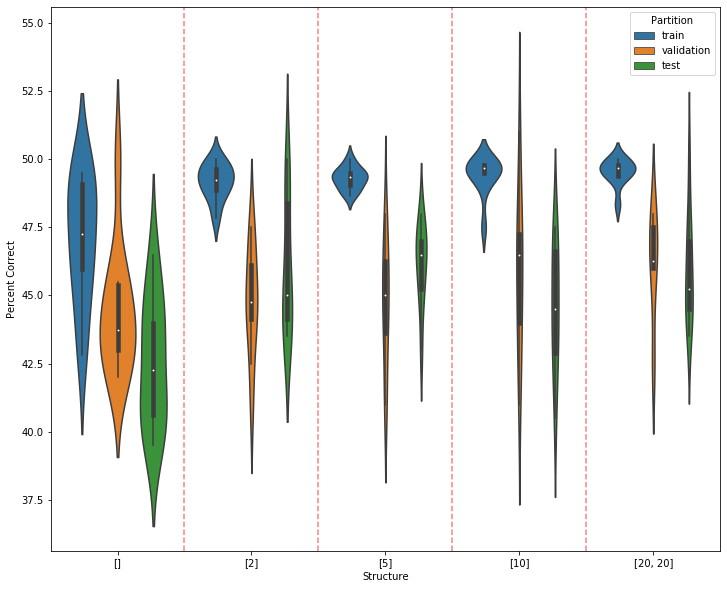

In [60]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Based on results in violin plots, pick best network structure (according to performance in validation data) and train a network using that structure.  Then apply the trained network using `nnet.use` on the training, validation and testing partitions.  Report the performance of each, and, for classification problems, show the confusion matrices.  See examples below.

In [62]:
nnet = NeuralNetworkClassifierTorch(Xflat.shape[1], [10], len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(Xflat, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 50 LL train 0.9970 val 0.6939
Epoch 100 LL train 0.9989 val 0.6578
Epoch 150 LL train 0.9993 val 0.6417
Epoch 200 LL train 0.9995 val 0.6288
Epoch 250 LL train 0.9996 val 0.6180
Epoch 300 LL train 0.9997 val 0.6089
Epoch 350 LL train 0.9998 val 0.6010
Epoch 400 LL train 0.9998 val 0.5942
Epoch 450 LL train 0.9998 val 0.5881
Epoch 500 LL train 0.9998 val 0.5827


NeuralNetworkClassifierTorch(400, [10], 2, device=cpu)

In [90]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 99.33333333333333


,0.0,1.0
0.0,98.666667,1.333333
1.0,0.000000,100.000000


In [91]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 90.0


,0.0,1.0
0.0,84.0,16.0
1.0,4.0,96.0


In [92]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 89.0


,0.0,1.0
0.0,86.0,14.0
1.0,8.0,92.0


In [36]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[5] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[10, 10] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[5] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] : Repetition 1 2 3 4 5 6 7 8 9 10 


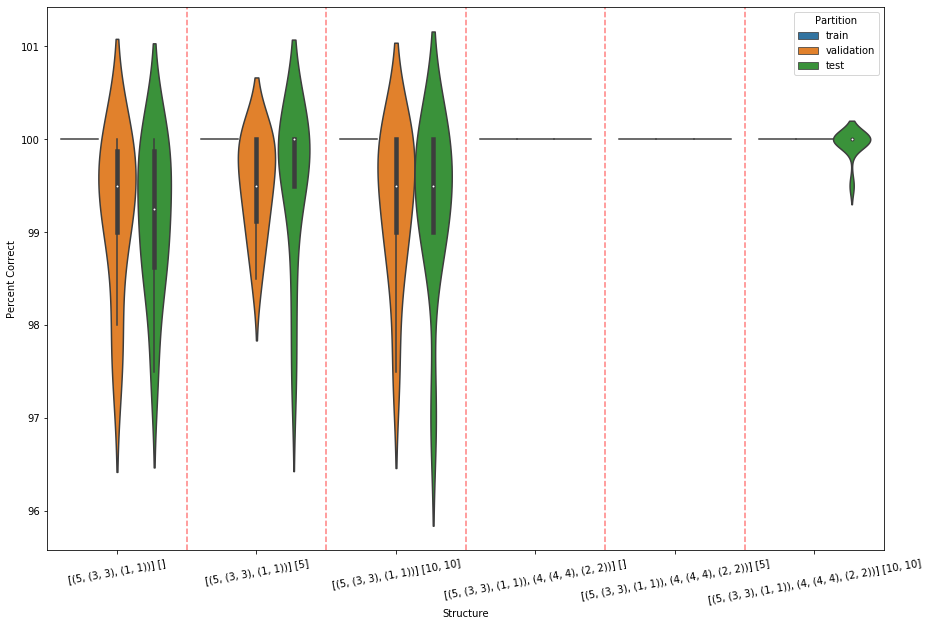

In [37]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Application to Three Data Sets

In the following experiments, you may try a variety of learning_rates, numbers of epochs, and network structures, but in the violin plot use one value for learning_rate, one value for number of epochs, and six values of network structure.

Apply `multiple_runs_regression` for various network structures to the automobile data introduced in Lecture Notes 17.  Load it as follows.

### DATASET 1

In [103]:
import pandas as pd
import os

if os.path.isfile('automobile.csv'):
    print('Reading data from \'automobile.csv\'.')
    automobile = pd.read_csv('automobile.csv')
else:
    print('Downloading auto-mpg.data from UCI ML Repository.')
    automobile = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                             header=None, delimiter='\s+', na_values='?', 
                             usecols=range(8))
    automobile.columns = ('mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                          'acceleration', 'year', 'origin')

    print(f'Number rows in original data file {len(automobile)}.')
    automobile = automobile.dropna(axis=0)
    print(f'Number rows after dropping rows with missing values {len(automobile)}.')
    automobile.to_csv('automobile.csv', index=False)  # so row numbers are not written to file

Reading data from 'automobile.csv'.


In [104]:
automobile

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [105]:
X = automobile [['mpg','cylinders','displacement','weight','acceleration','year','origin']]
T= automobile[['displacement']]
X=np.asarray(X)
T=np.asarray(T)

In [106]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [100, 100]
n_epochs = 1000
learning_rate = 0.001

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [92]:
results

[['[100, 100]', 'train', 1.5212554555350144],
 ['[100, 100]', 'validation', 3.1138253139035452],
 ['[100, 100]', 'test', 2.640076045643081],
 ['[100, 100]', 'train', 1.6415685533664706],
 ['[100, 100]', 'validation', 3.0929473977173707],
 ['[100, 100]', 'test', 1.8941534626630374],
 ['[100, 100]', 'train', 1.6445273136035],
 ['[100, 100]', 'validation', 1.9186718638613554],
 ['[100, 100]', 'test', 2.592145646683474],
 ['[100, 100]', 'train', 1.7693981920003636],
 ['[100, 100]', 'validation', 4.53275850057548],
 ['[100, 100]', 'test', 3.004987196295812],
 ['[100, 100]', 'train', 1.4659066144563815],
 ['[100, 100]', 'validation', 1.8272511428767102],
 ['[100, 100]', 'test', 1.6861255921499092],
 ['[100, 100]', 'train', 1.649517504266846],
 ['[100, 100]', 'validation', 2.343036340253015],
 ['[100, 100]', 'test', 2.7223841647669005],
 ['[100, 100]', 'train', 1.7653512834540803],
 ['[100, 100]', 'validation', 2.1136680994930126],
 ['[100, 100]', 'test', 2.257005399358316],
 ['[100, 100]', '

In [93]:
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

,Structure,Partition,RMSE
0,"[100, 100]",train,1.521255
1,"[100, 100]",validation,3.113825
2,"[100, 100]",test,2.640076
3,"[100, 100]",train,1.641569
4,"[100, 100]",validation,3.092947
5,"[100, 100]",test,1.894153
6,"[100, 100]",train,1.644527
7,"[100, 100]",validation,1.918672
8,"[100, 100]",test,2.592146
9,"[100, 100]",train,1.769398


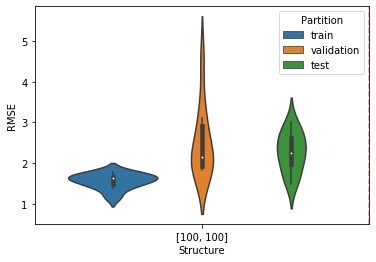

In [94]:
import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [162]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [100, 100]
n_epochs = 500
learning_rate = 0.001

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [163]:
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

,Structure,Partition,RMSE
0,"[100, 100]",train,2.456655
1,"[100, 100]",validation,2.812978
2,"[100, 100]",test,2.570026
3,"[100, 100]",train,2.635188
4,"[100, 100]",validation,3.035196
5,"[100, 100]",test,3.884748
6,"[100, 100]",train,2.634123
7,"[100, 100]",validation,3.198500
8,"[100, 100]",test,3.850703
9,"[100, 100]",train,3.041179


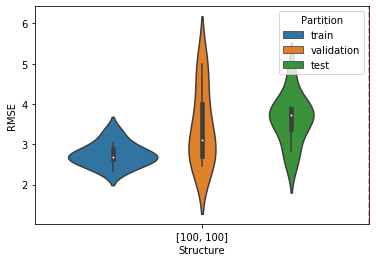

In [164]:
import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [165]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = []
n_epochs = 1000
learning_rate = 0.001

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 


In [166]:
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

,Structure,Partition,RMSE
0,[],train,18.702118
1,[],validation,20.158008
2,[],test,19.349854
3,[],train,13.777574
4,[],validation,14.875807
5,[],test,14.489100
6,[],train,6.226141
7,[],validation,6.089387
8,[],test,6.790057
9,[],train,11.272343


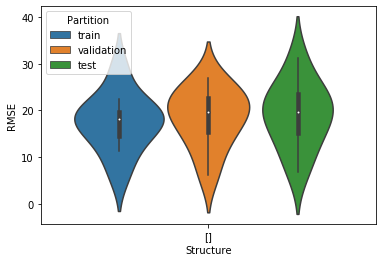

In [167]:
import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [168]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [100,100,100]
n_epochs = 1000
learning_rate = 0.001

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

Structure [100, 100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [169]:
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

,Structure,Partition,RMSE
0,"[100, 100, 100]",train,0.864137
1,"[100, 100, 100]",validation,1.515906
2,"[100, 100, 100]",test,2.076712
3,"[100, 100, 100]",train,0.841889
4,"[100, 100, 100]",validation,1.880290
5,"[100, 100, 100]",test,1.948258
6,"[100, 100, 100]",train,0.882645
7,"[100, 100, 100]",validation,1.581196
8,"[100, 100, 100]",test,1.521553
9,"[100, 100, 100]",train,0.864696


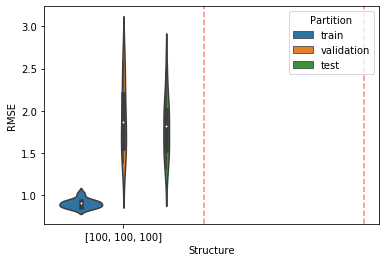

In [170]:
import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


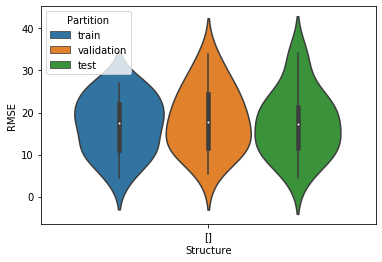

In [107]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = []
n_epochs = 1000
learning_rate = 0.001

n_partitions = 20
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


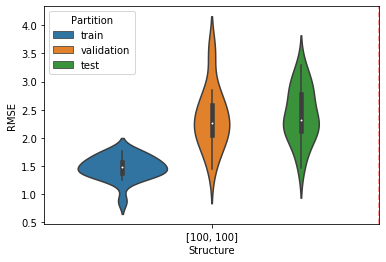

In [108]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [100,100]
n_epochs = 1000
learning_rate = 0.001

n_partitions = 20
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Structure [20]: Repetition 1 2 3 4 5 6 7 8 9 10 


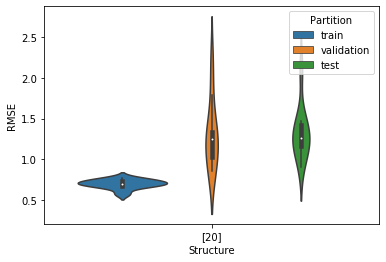

In [109]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [20]
n_epochs = 500
learning_rate = 0.05

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Structure [20]: Repetition 1 2 3 4 5 6 7 8 9 10 


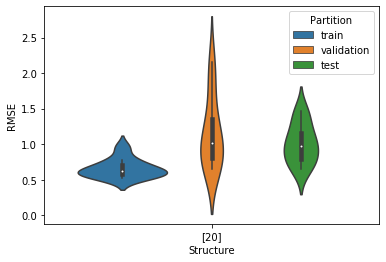

In [110]:
fractions = (0.6, 0.2, 0.2,0.5)
n_hiddens_list = [20]
n_epochs = 500
learning_rate = 0.05

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 


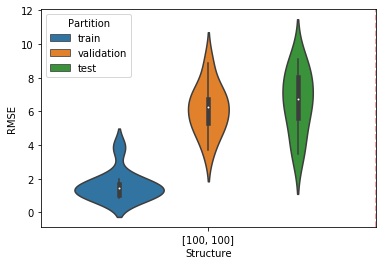

In [111]:
fractions = (0.6, 0.2, 0.2,0.2)
n_hiddens_list = [100,100]
n_epochs = 500
learning_rate = 0.05

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Structure [100]: Repetition 1 2 3 4 5 6 7 8 9 10 


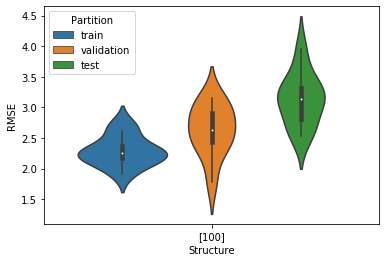

In [112]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [100]
n_epochs = 1000
learning_rate = 0.001

n_partitions = 10
results = multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate)

resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

import seaborn as sns

sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

#### Result

1. Here we are applying regression neural network to the automobile data. This is the automobile data against MPG data. OS package has 'OS.' path where '.' is file function.We can call on any system if you are running Python. 
2. Multiple runs means that we are doing multiple partitions so that is the only thing that the for loop does is to check for different partitions so we call partition function each time.
3. Then we create a neural network and train it to get the results of applying it to training, validation and test partitions. 
4. Multiple runs classification should be creating a different kind of a neural network. 
5. As the number of hidden layer increases, the validation rate and accuracy rate decrease. This is because of more hidden layer will tend to get stuck easily with the model, thus ends up being overfitting.Thus, it is preferable to have lesser number of hidden layers for classication of networks.
6. As number of partitions increases,there seem to be variations because of usage of ranndom weight values thus it will results in consistency. So, it is necesaary to train a model with more number of partitions.
7. Violin plots are a way of plotting a numeric data with a combination of box plot and density pot. We can find median, interquartile rand and adjacent values. 
8. As number of hidden list listed, the median value tend to be higher which shows that median value is directly proporational to number of hidden list.
9. The range of RMSE tend to more in the case of validation data as compared to train and test data. As the number of hidden list increases the range tend to be less which shows the RSME plays an important role.
10. That is why error value reduces to a near zero at certain epoch based on the hidden layer.More hidden layer will over fit the data and lesser hidden layer will under fit the data.

### DATASET 2

Apply `multiple_runs_classification` for various network structures to the following data set from a study in diabetes diagnosis.

In [151]:
if os.path.isfile('diabetes.csv'):
    print('Reading data from \'diabetes.csv\'.')
    diabetes = pd.read_csv('diabetes.csv')
else:
    print('Downloading diabetes_data_upload.csv from UCI ML Repository.')
    diabetes = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv')
                        # usecols=range(1,14))
    if False:
        print(f'Number rows in original data file {len(diabetes)}.')
        diabetes = diabetes.dropna(axis=0)
        print(f'Number rows after dropping rows with missing values {len(diabetes)}.')
    converter = dict(Yes=1, No=0, Female=1, Male=0, Positive=1, Negative=0)
    diabetes = diabetes.applymap(lambda x: converter.get(x, x))
    diabetes.to_csv('diabetes.csv', index=False)  # so row numbers are not written to file
X = diabetes.iloc[:, :-1].values
T = diabetes.iloc[:, -1:].values

X.shape, T.shape

#X=np.asarray(X)
#T=np.asarray(T)


Reading data from 'diabetes.csv'.


((520, 16), (520, 1))

In [117]:
diabetes

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,1,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,1,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


In [75]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


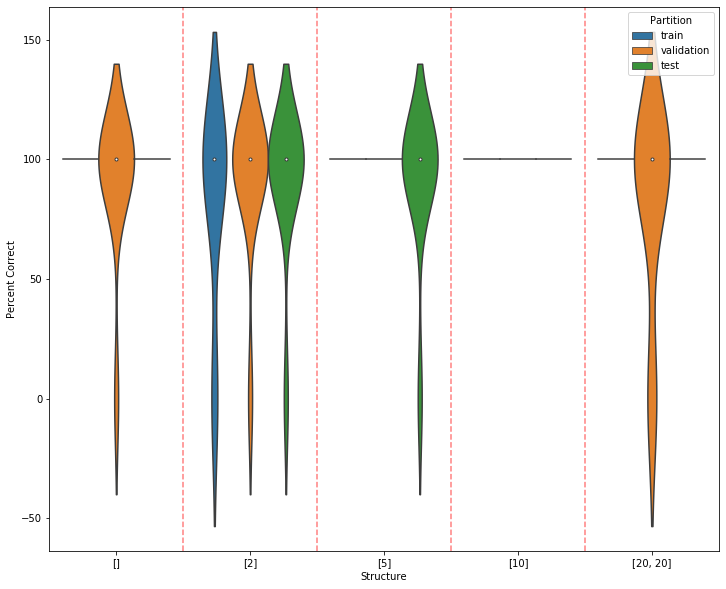

In [77]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [81]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 50 LL train 0.9005 val 0.7930
Epoch 100 LL train 0.9578 val 0.8305
Epoch 150 LL train 0.9814 val 0.8293
Epoch 200 LL train 0.9899 val 0.8251
Epoch 250 LL train 0.9938 val 0.8197
Epoch 300 LL train 0.9958 val 0.8163
Epoch 350 LL train 0.9968 val 0.8129
Epoch 400 LL train 0.9975 val 0.8101
Epoch 450 LL train 0.9980 val 0.8076
Epoch 500 LL train 0.9984 val 0.8054


NeuralNetworkClassifierTorch(16, [10], 2, device=cpu)

In [82]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 38.46153846153847


,0,1
0,100.000000,0.000000
1,0.520833,99.479167


In [83]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 38.46153846153847


,0,1
0,95.00,5.00
1,6.25,93.75


In [84]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 38.46153846153847


,0,1
0,97.5000,2.5000
1,17.1875,82.8125


In [85]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


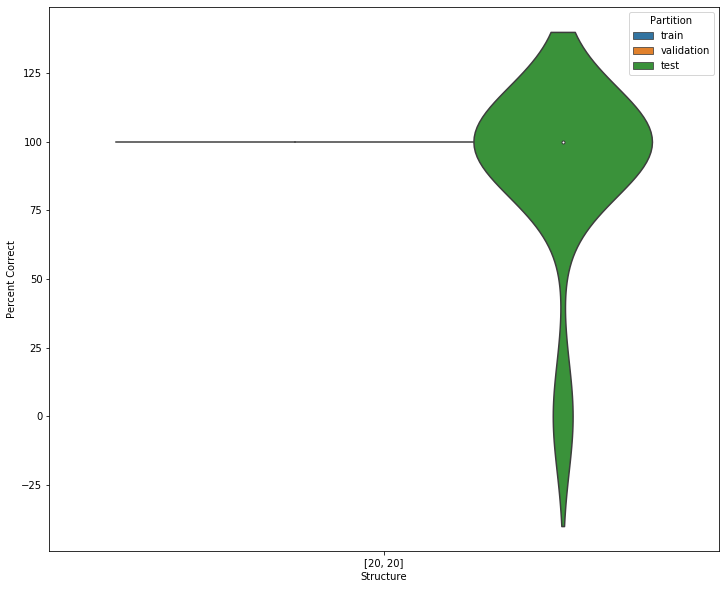

In [86]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [90]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)))
Xtrain1, Ttrain1, Xval1, Tval1, Xtest1, Ttest1 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain1, Ttrain1, n_epochs, learning_rate, method='adam', Xval=Xval1, Tval=Tval1, verbose=True)

Epoch 50 LL train 0.8600 val 0.8043
Epoch 100 LL train 0.9115 val 0.8433
Epoch 150 LL train 0.9527 val 0.8249
Epoch 200 LL train 0.9756 val 0.8079
Epoch 250 LL train 0.9829 val 0.8001
Epoch 300 LL train 0.9860 val 0.7915
Epoch 350 LL train 0.9877 val 0.7832
Epoch 400 LL train 0.9889 val 0.7752
Epoch 450 LL train 0.9898 val 0.7672
Epoch 500 LL train 0.9906 val 0.7590


NeuralNetworkClassifierTorch(16, [10], 2, device=cpu)

In [91]:
C_train, P_train = nnet.use(Xtrain1)
confusion_matrix(C_train, Ttrain1)

Percent Correct is 38.46153846153847


,0,1
0,96.666667,3.333333
1,4.166667,95.833333


In [92]:
C_val, P_val = nnet.use(Xval1)
confusion_matrix(C_val, Tval1)

Percent Correct is 38.46153846153847


,0,1
0,92.500,7.500
1,9.375,90.625


In [93]:
C_test, P_test = nnet.use(Xtest1)
confusion_matrix(C_test, Ttest1)

Percent Correct is 38.46153846153847


,0,1
0,85.000,15.000
1,3.125,96.875


In [94]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 


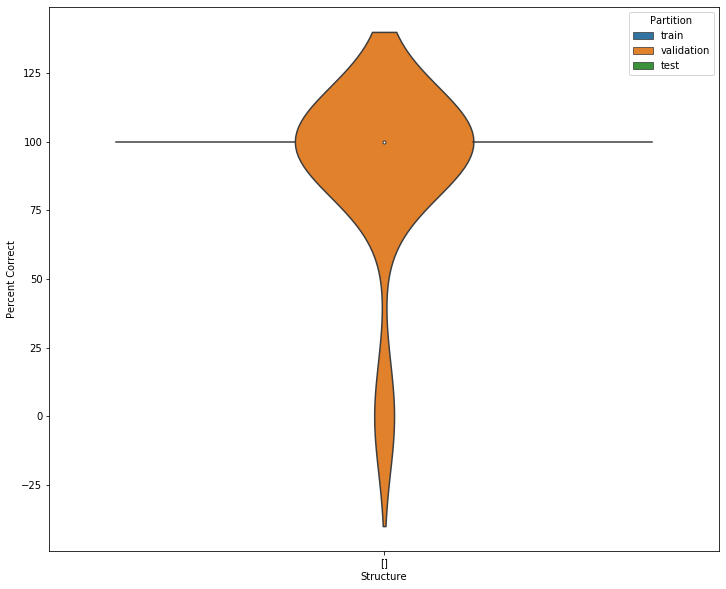

In [95]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [96]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)))
Xtrain2, Ttrain2, Xval2, Tval2, Xtest2, Ttest2 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain2, Ttrain2, n_epochs, learning_rate, method='adam', Xval=Xval2, Tval=Tval2, verbose=True)

Epoch 50 LL train 0.8593 val 0.7907
Epoch 100 LL train 0.9235 val 0.7726
Epoch 150 LL train 0.9551 val 0.7599
Epoch 200 LL train 0.9708 val 0.7614
Epoch 250 LL train 0.9779 val 0.7548
Epoch 300 LL train 0.9816 val 0.7497
Epoch 350 LL train 0.9839 val 0.7455
Epoch 400 LL train 0.9854 val 0.7416
Epoch 450 LL train 0.9867 val 0.7374
Epoch 500 LL train 0.9877 val 0.7326


NeuralNetworkClassifierTorch(16, [10], 2, device=cpu)

In [97]:
C_train, P_train = nnet.use(Xtrain2)
confusion_matrix(C_train, Ttrain2)

Percent Correct is 38.46153846153847


,0,1
0,95.000000,5.000000
1,4.166667,95.833333


In [98]:
C_val, P_val = nnet.use(Xval2)
confusion_matrix(C_val, Tval2)

Percent Correct is 38.46153846153847


,0,1
0,90.0000,10.0000
1,7.8125,92.1875


In [99]:
C_test, P_test = nnet.use(Xtest2)
confusion_matrix(C_test, Ttest2)

Percent Correct is 38.46153846153847


,0,1
0,92.50,7.50
1,6.25,93.75


In [103]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[100,100]]  # Notice the first one... []
n_epochs = 1000
learning_rate = 0.05

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 


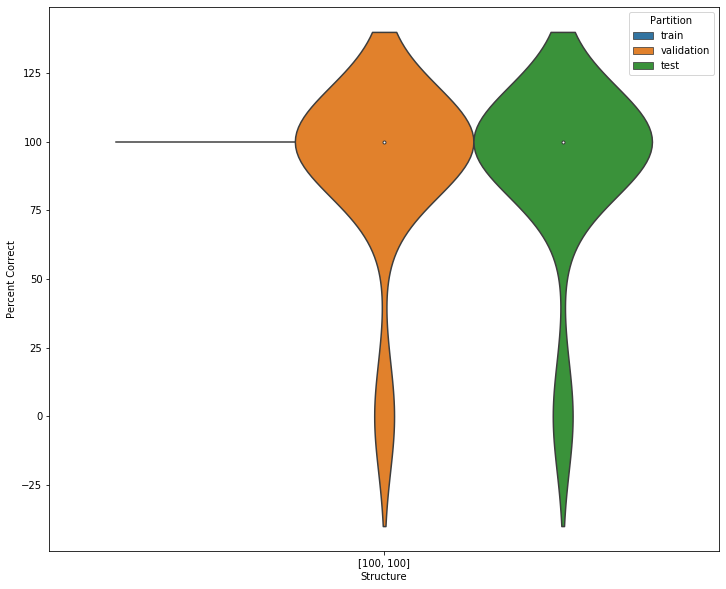

In [104]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [106]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)))
Xtrain3, Ttrain3, Xval3, Tval3, Xtest3, Ttest3 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain3, Ttrain3, n_epochs, learning_rate, method='adam', Xval=Xval3, Tval=Tval3,verbose=True)

Epoch 100 LL train 0.9898 val 0.7234
Epoch 200 LL train 0.9961 val 0.6964
Epoch 300 LL train 0.9980 val 0.6553
Epoch 400 LL train 0.9988 val 0.5796
Epoch 500 LL train 0.9992 val 0.5354
Epoch 600 LL train 0.9995 val 0.5111
Epoch 700 LL train 0.9996 val 0.4954
Epoch 800 LL train 0.9997 val 0.4837
Epoch 900 LL train 0.9998 val 0.4745
Epoch 1000 LL train 0.9998 val 0.4667


NeuralNetworkClassifierTorch(16, [10], 2, device=cpu)

In [97]:
C_train, P_train = nnet.use(Xtrain2)
confusion_matrix(C_train, Ttrain2)

Percent Correct is 38.46153846153847


,0,1
0,95.000000,5.000000
1,4.166667,95.833333


In [98]:
C_val, P_val = nnet.use(Xval2)
confusion_matrix(C_val, Tval2)

Percent Correct is 38.46153846153847


,0,1
0,90.0000,10.0000
1,7.8125,92.1875


In [99]:
C_test, P_test = nnet.use(Xtest2)
confusion_matrix(C_test, Ttest2)

Percent Correct is 38.46153846153847


,0,1
0,92.50,7.50
1,6.25,93.75


Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [100]: Repetition 1 2 3 4 5 6 7 8 9 10 


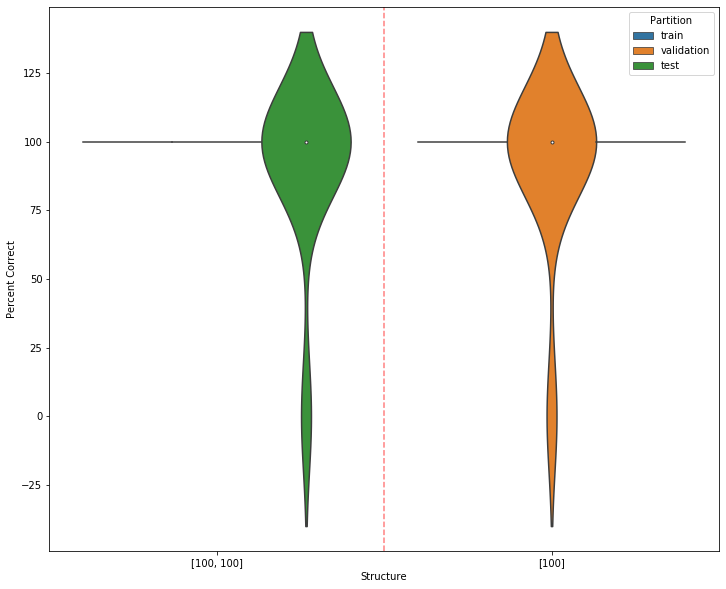

In [120]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[100,100],[100]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.05

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [121]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)))
Xtrain3, Ttrain3, Xval3, Tval3, Xtest3, Ttest3 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain3, Ttrain3, n_epochs, learning_rate, method='adam', Xval=Xval3, Tval=Tval3,verbose=True)

C_train, P_train = nnet.use(Xtrain3)
confusion_matrix(C_train, Ttrain3)

C_val, P_val = nnet.use(Xval3)
confusion_matrix(C_val, Tval3)

C_test, P_test = nnet.use(Xtest3)
confusion_matrix(C_test, Ttest3)

Epoch 50 LL train 0.9672 val 0.8567
Epoch 100 LL train 0.9883 val 0.8560
Epoch 150 LL train 0.9914 val 0.8264
Epoch 200 LL train 0.9935 val 0.8026
Epoch 250 LL train 0.9949 val 0.7903
Epoch 300 LL train 0.9962 val 0.7820
Epoch 350 LL train 0.9970 val 0.7770
Epoch 400 LL train 0.9975 val 0.7768
Epoch 450 LL train 0.9980 val 0.7758
Epoch 500 LL train 0.9984 val 0.7764
Percent Correct is 38.46153846153847
Percent Correct is 38.46153846153847
Percent Correct is 38.46153846153847


,0,1
0,95.0,5.0
1,0.0,100.0


Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [100]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [1, 5]: Repetition 1 2 3 4 5 6 7 8 9 10 


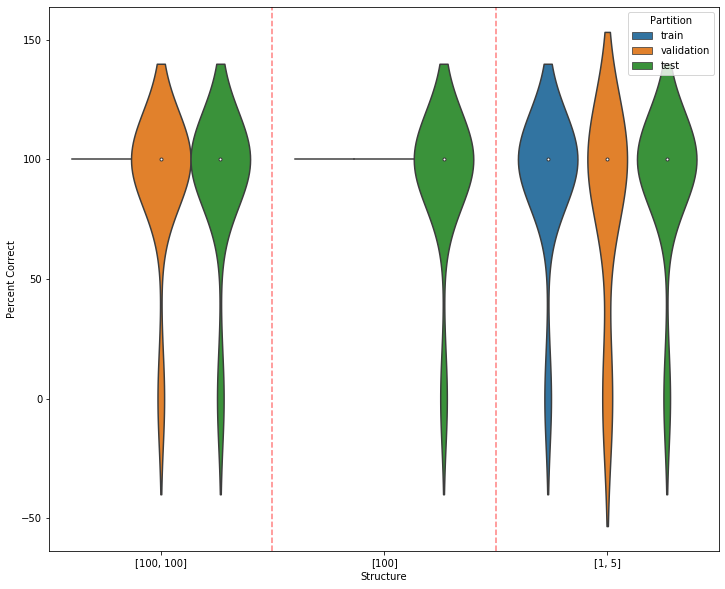

In [122]:
fractions = (0.6, 0.2, 0.2,0.2)
n_hiddens_list = [[100,100],[100],[1,5]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.001

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [121]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)))
Xtrain3, Ttrain3, Xval3, Tval3, Xtest3, Ttest3 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain3, Ttrain3, n_epochs, learning_rate, method='adam', Xval=Xval3, Tval=Tval3,verbose=True)

C_train, P_train = nnet.use(Xtrain3)
confusion_matrix(C_train, Ttrain3)

C_val, P_val = nnet.use(Xval3)
confusion_matrix(C_val, Tval3)

C_test, P_test = nnet.use(Xtest3)
confusion_matrix(C_test, Ttest3)

Epoch 50 LL train 0.9672 val 0.8567
Epoch 100 LL train 0.9883 val 0.8560
Epoch 150 LL train 0.9914 val 0.8264
Epoch 200 LL train 0.9935 val 0.8026
Epoch 250 LL train 0.9949 val 0.7903
Epoch 300 LL train 0.9962 val 0.7820
Epoch 350 LL train 0.9970 val 0.7770
Epoch 400 LL train 0.9975 val 0.7768
Epoch 450 LL train 0.9980 val 0.7758
Epoch 500 LL train 0.9984 val 0.7764
Percent Correct is 38.46153846153847
Percent Correct is 38.46153846153847
Percent Correct is 38.46153846153847


,0,1
0,95.0,5.0
1,0.0,100.0


#### Result 

1. Here we are applying classification neural network to the diabetes data. This is the diabetes patient records obtained from electronic recording device and paper records.OS package has 'OS.' path where '.' is file function.We can call on any system if you are running Python. 
2. Multiple classification runs for class classification which have tp get the percent correct instead of RMSE. 
3. Then we create a neural network and train it to get the results of applying it to training, validation and test partitions. 
4. Multiple runs classification should be creating a different kind of a neural network. 
5. The main difference between between multiple_runs_regression and multiple_runs_classification is the way of initializing and inputs into function for the convolution. Instead of RMSE, we are utilizing percent correct in this function. 
6. Accuracies shows how our classifers classifies the data from the diabetes data. It focusses on how much classifiers correctly classified within training and validation partion.
7. More the data being classified, hihger the accuracy. But it is not possible to get 100 percent accuracy because it is hard to fit parameters with respet to all the data.  
8. Validation data set is an hidden data set where more the network gets along woth the training data , less the fitting of validation data tend to be formed. Only reason to reduce the validation error is to overfitting of data which will increase the fit of training data.
9. As the number of hidden layer increases, the validation rate and accuracy rate decrease as similar to regression. This is because of more hidden layer will tend to get stuck easily with the model, thus ends up being overfitting.Thus, it is preferable to have lesser number of hidden layers for classication of networks.
10. As number of partitions increases,there seem to be variations because of usage of random weights which will results in consistency. Thus, we should have more partition in order to obtain the best validation value.
11. Violin plots are a way of plotting a numeric data with a combination of box plot and density pot. We can find median, interquartile rand and adjacent values. 
12. As number of hidden list listed, the median value is higher which shows that it is directly proporational to number of hidden list.
13. Classification model helps in predicting one of a set of categories like given an image and ask to distinguish between cat and dog.Classification model is the most commly ised in Convolutional Neural Network as it deals with machine learning and deep learning which would be interesting to see the specific label along with training data comes in a format (data,label). If we are talking about image processing, the training data would be shows as a set of images with labels , as they would not be labelled with numbers or probability. 
14. Neural networks tend to imply the way human brain uses classification rules. Way each layer output becomes the input for the next layer depending on the percent correct function and optimizer. After all that process, it tend to act like an usual neural network. 
15. Percent Correct = 38.46153846153847

#### DATASET 3

Apply `multiple_runs_convolutional` for various network structures to the following small subset of the MNIST data that contains 500 samples of each digit.

In [124]:
if os.path.isfile('small_mnist.npy'):
    print('Reading data from \'small_mnist.npz\'.')
    small_mnist = np.load('small_mnist.npz')
else:
    import shlex
    import subprocess
    print('Downloading small_mnist.npz from CS545 site.')
    cmd = 'curl "https://www.cs.colostate.edu/~anderson/cs545/notebooks/small_mnist.npz" -o "small_mnist.npz"'
    subprocess.call(shlex.split(cmd))
    small_mnist = np.load('small_mnist.npz')


X = small_mnist['X']
X = X.reshape(-1, 1, 28, 28)
T = small_mnist['T']

X.shape, T.shape

((1000, 1, 28, 28), (1000, 1))

In [38]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[5] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[10, 10] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[5] : Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] : Repetition 1 2 3 4 5 6 7 8 9 10 


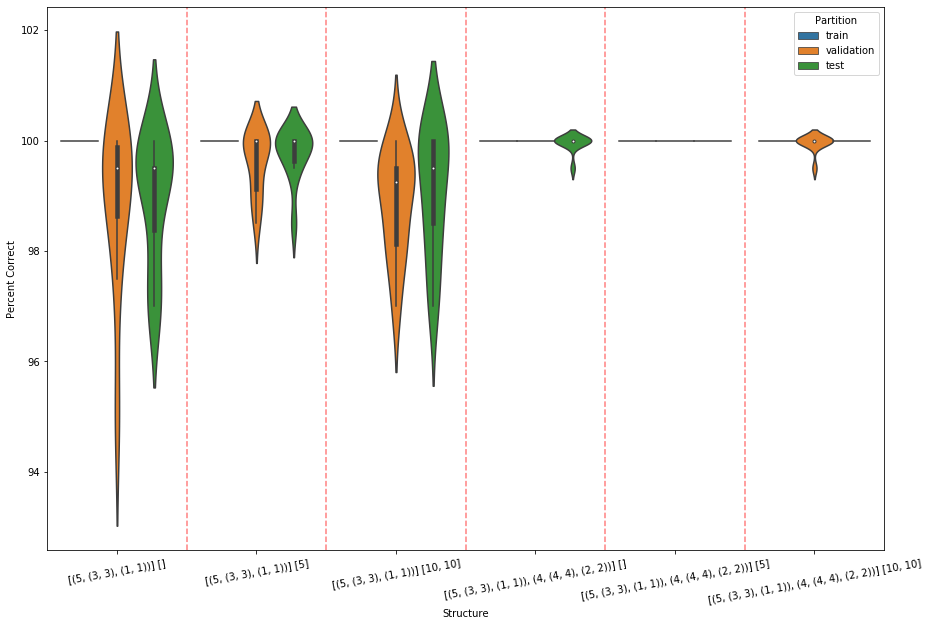

In [39]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [62]:
for nconv in n_conv_list:
    for nfc in n_fc_list:
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:],nconv,nfc,len(np.unique(T)))
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 20 LL train 0.9794 val 0.8306
Epoch 40 LL train 0.9986 val 0.9095
Epoch 60 LL train 0.9995 val 0.9270
Epoch 80 LL train 0.9996 val 0.9354
Epoch 100 LL train 0.9997 val 0.9418
Epoch 120 LL train 0.9998 val 0.9461
Epoch 140 LL train 0.9998 val 0.9498
Epoch 160 LL train 0.9998 val 0.9532
Epoch 180 LL train 0.9998 val 0.9561
Epoch 200 LL train 0.9999 val 0.9587
Epoch 20 LL train 0.8736 val 0.8955
Epoch 40 LL train 0.9758 val 0.9712
Epoch 60 LL train 0.9882 val 0.9831
Epoch 80 LL train 0.9920 val 0.9860
Epoch 100 LL train 0.9940 val 0.9854
Epoch 120 LL train 0.9952 val 0.9871
Epoch 140 LL train 0.9961 val 0.9882
Epoch 160 LL train 0.9967 val 0.9886
Epoch 180 LL train 0.9972 val 0.9889
Epoch 200 LL train 0.9976 val 0.9892
Epoch 20 LL train 0.8913 val 0.8327
Epoch 40 LL train 0.9955 val 0.9849
Epoch 60 LL train 0.9984 val 0.9983
Epoch 80 LL train 0.9989 val 0.9989
Epoch 100 LL train 0.9992 val 0.9992
Epoch 120 LL train 0.9994 val 0.9993
Epoch 140 LL train 0.9995 val 0.9995
Epoch 160 LL 

In [64]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [65]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [66]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [67]:
fractions = (0.6, 0.2, 0.2,0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 


In [68]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 


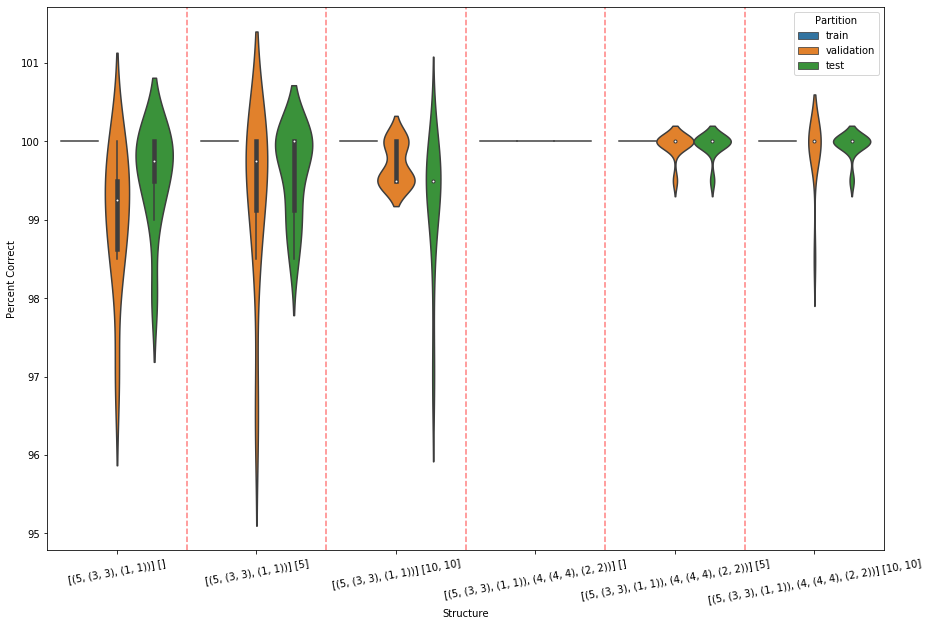

In [69]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [70]:
for nconv in n_conv_list:
    for nfc in n_fc_list:
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:],nconv,nfc,len(np.unique(T)))
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 20 LL train 0.8950 val 0.8756
Epoch 40 LL train 0.9826 val 0.9803
Epoch 60 LL train 0.9946 val 0.9918
Epoch 80 LL train 0.9964 val 0.9945
Epoch 100 LL train 0.9973 val 0.9956
Epoch 120 LL train 0.9979 val 0.9965
Epoch 140 LL train 0.9982 val 0.9971
Epoch 160 LL train 0.9985 val 0.9975
Epoch 180 LL train 0.9988 val 0.9979
Epoch 200 LL train 0.9989 val 0.9982
Epoch 20 LL train 0.8706 val 0.8113
Epoch 40 LL train 0.9792 val 0.9562
Epoch 60 LL train 0.9914 val 0.9895
Epoch 80 LL train 0.9944 val 0.9934
Epoch 100 LL train 0.9958 val 0.9950
Epoch 120 LL train 0.9966 val 0.9960
Epoch 140 LL train 0.9972 val 0.9966
Epoch 160 LL train 0.9977 val 0.9972
Epoch 180 LL train 0.9980 val 0.9976
Epoch 200 LL train 0.9983 val 0.9979
Epoch 20 LL train 0.9844 val 0.9446
Epoch 40 LL train 0.9978 val 0.9253
Epoch 60 LL train 0.9987 val 0.9098
Epoch 80 LL train 0.9990 val 0.9115
Epoch 100 LL train 0.9992 val 0.9105
Epoch 120 LL train 0.9993 val 0.9081
Epoch 140 LL train 0.9994 val 0.9057
Epoch 160 LL 

In [71]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [72]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [73]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [81]:
fractions = (0.6, 0.2, 0.2,0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 20

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
conv [(5, (3, 3), (1, 1))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
conv [(5, (3, 3), (1, 1))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


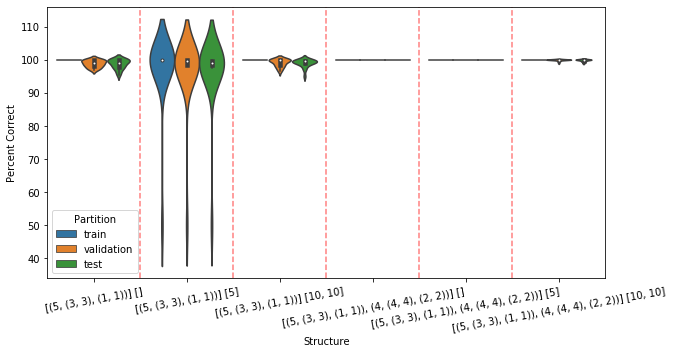

In [82]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [83]:
for nconv in n_conv_list:
    for nfc in n_fc_list:
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:],nconv,nfc,len(np.unique(T)))
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 20 LL train 0.9750 val 0.9339
Epoch 40 LL train 0.9982 val 0.9772
Epoch 60 LL train 0.9993 val 0.9783
Epoch 80 LL train 0.9995 val 0.9816
Epoch 100 LL train 0.9996 val 0.9814
Epoch 120 LL train 0.9997 val 0.9823
Epoch 140 LL train 0.9997 val 0.9829
Epoch 160 LL train 0.9998 val 0.9836
Epoch 180 LL train 0.9998 val 0.9841
Epoch 200 LL train 0.9998 val 0.9847
Epoch 20 LL train 0.9445 val 0.8980
Epoch 40 LL train 0.9897 val 0.9834
Epoch 60 LL train 0.9947 val 0.9940
Epoch 80 LL train 0.9963 val 0.9958
Epoch 100 LL train 0.9972 val 0.9968
Epoch 120 LL train 0.9978 val 0.9974
Epoch 140 LL train 0.9981 val 0.9979
Epoch 160 LL train 0.9984 val 0.9982
Epoch 180 LL train 0.9987 val 0.9985
Epoch 200 LL train 0.9988 val 0.9987
Epoch 20 LL train 0.9569 val 0.9293
Epoch 40 LL train 0.9965 val 0.9280
Epoch 60 LL train 0.9983 val 0.9198
Epoch 80 LL train 0.9987 val 0.9164
Epoch 100 LL train 0.9990 val 0.9153
Epoch 120 LL train 0.9991 val 0.9143
Epoch 140 LL train 0.9993 val 0.9132
Epoch 160 LL 

In [84]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [85]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [86]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [88]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 1000
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[5] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 


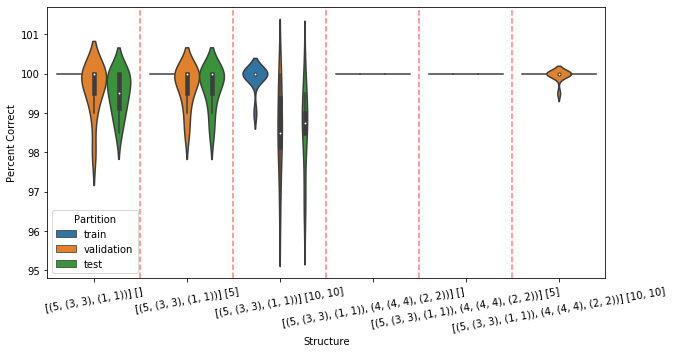

In [89]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [90]:
for nconv in n_conv_list:
    for nfc in n_fc_list:
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:],nconv,nfc,len(np.unique(T)))
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 100 LL train 0.9972 val 0.9768
Epoch 200 LL train 0.9990 val 0.9861
Epoch 300 LL train 0.9995 val 0.9899
Epoch 400 LL train 0.9997 val 0.9920
Epoch 500 LL train 0.9998 val 0.9933
Epoch 600 LL train 0.9998 val 0.9943
Epoch 700 LL train 0.9999 val 0.9950
Epoch 800 LL train 0.9999 val 0.9955
Epoch 900 LL train 0.9999 val 0.9960
Epoch 1000 LL train 0.9999 val 0.9963
Epoch 100 LL train 0.9946 val 0.9929
Epoch 200 LL train 0.9978 val 0.9971
Epoch 300 LL train 0.9988 val 0.9983
Epoch 400 LL train 0.9992 val 0.9989
Epoch 500 LL train 0.9994 val 0.9992
Epoch 600 LL train 0.9996 val 0.9994
Epoch 700 LL train 0.9996 val 0.9995
Epoch 800 LL train 0.9997 val 0.9996
Epoch 900 LL train 0.9998 val 0.9997
Epoch 1000 LL train 0.9998 val 0.9997
Epoch 100 LL train 0.9988 val 0.9988
Epoch 200 LL train 0.9995 val 0.9994
Epoch 300 LL train 0.9997 val 0.9997
Epoch 400 LL train 0.9998 val 0.9998
Epoch 500 LL train 0.9998 val 0.9998
Epoch 600 LL train 0.9999 val 0.9999
Epoch 700 LL train 0.9999 val 0.9999

In [91]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [92]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [93]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [94]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]]
n_fc_list = [[10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.001

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 


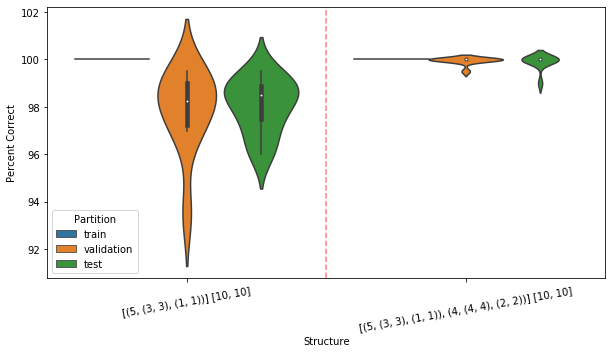

In [99]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [95]:
for nconv in n_conv_list:
    for nfc in n_fc_list:
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:],nconv,nfc,len(np.unique(T)))
        Xtrain3, Ttrain3, Xval3, Tval3, Xtest3, Ttest3 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
        nnet.train(Xtrain3, Ttrain3, n_epochs, learning_rate, method='adam', Xval=Xval3, Tval=Tval3, verbose=True)

Epoch 20 LL train 0.6766 val 0.6374
Epoch 40 LL train 0.8042 val 0.7376
Epoch 60 LL train 0.9017 val 0.8263
Epoch 80 LL train 0.9416 val 0.8577
Epoch 100 LL train 0.9589 val 0.8668
Epoch 120 LL train 0.9684 val 0.8698
Epoch 140 LL train 0.9746 val 0.8707
Epoch 160 LL train 0.9789 val 0.8704
Epoch 180 LL train 0.9821 val 0.8696
Epoch 200 LL train 0.9845 val 0.8684
Epoch 20 LL train 0.5550 val 0.5643
Epoch 40 LL train 0.6460 val 0.6456
Epoch 60 LL train 0.7867 val 0.7704
Epoch 80 LL train 0.9306 val 0.9282
Epoch 100 LL train 0.9722 val 0.9717
Epoch 120 LL train 0.9814 val 0.9814
Epoch 140 LL train 0.9856 val 0.9856
Epoch 160 LL train 0.9883 val 0.9883
Epoch 180 LL train 0.9902 val 0.9903
Epoch 200 LL train 0.9917 val 0.9917


In [96]:
C_train, P_train = nnet.use(Xtrain3)
confusion_matrix(C_train, Ttrain3)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [97]:
C_val, P_val = nnet.use(Xval3)
confusion_matrix(C_val, Tval3)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [98]:
C_test, P_test = nnet.use(Xtest3)
confusion_matrix(C_test, Ttest3)

Percent Correct is 50.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [126]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]]
n_fc_list = [[10, 10]]  # Notice the first one... []
n_epochs = 1000
learning_rate = 0.05

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

conv [(5, (3, 3), (1, 1))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 
conv [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] FC:[10, 10] Repetition 1 2 3 4 5 6 7 8 9 10 


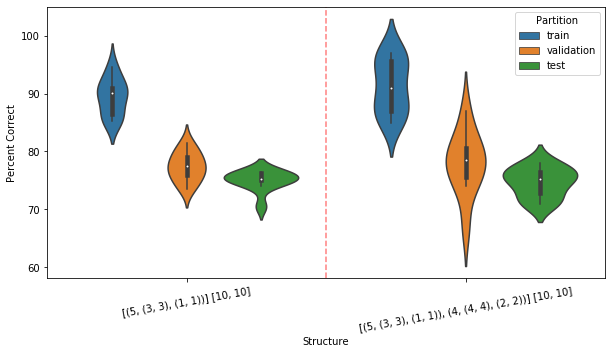

In [127]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [128]:
for nconv in n_conv_list:
    for nfc in n_fc_list:
        nnet = NeuralNetworkClassifierConvolutionalTorch(np.shape(X)[-3:],nconv,nfc,len(np.unique(T)))
        Xtrain3, Ttrain3, Xval3, Tval3, Xtest3, Ttest3 = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
        nnet.train(Xtrain3, Ttrain3, n_epochs, learning_rate, method='adam', Xval=Xval3, Tval=Tval3, verbose=True)

Epoch 100 LL train 0.8713 val 0.2880
Epoch 200 LL train 0.9674 val 0.2496
Epoch 300 LL train 0.9752 val 0.2248
Epoch 400 LL train 0.6047 val 0.4142
Epoch 500 LL train 0.7674 val 0.3947
Epoch 600 LL train 0.8271 val 0.3148
Epoch 700 LL train 0.8776 val 0.2876
Epoch 800 LL train 0.8976 val 0.2573
Epoch 900 LL train 0.9040 val 0.2104
Epoch 1000 LL train 0.9094 val 0.2056
Epoch 100 LL train 0.9283 val 0.2660
Epoch 200 LL train 0.9358 val 0.2546
Epoch 300 LL train 0.9925 val 0.2424
Epoch 400 LL train 0.9952 val 0.2209
Epoch 500 LL train 0.9960 val 0.2099
Epoch 600 LL train 0.9964 val 0.1993
Epoch 700 LL train 0.9967 val 0.1874
Epoch 800 LL train 0.9969 val 0.1796
Epoch 900 LL train 0.9970 val 0.1736
Epoch 1000 LL train 0.9971 val 0.1684


### Results

1. For this experiment, I have selected NeuralNetwork Convolutional class on MNIST data set which is a set of images of handwritten digits where all the images have a size of 28 *28 pixels.
2. Neural Network Convolutional Class has torch.nn.module which constructs neural network with inital convolational layer with connected layers.
3. This Convolution class reads the MNIST data into three types of tuples.It exacts the image data and target data from the dataset.
4. From the results, the network with less number of layers provides the best validation data as it provides lower validation data as layers increases. 
5. As we are increasing the learning rate, there is not any improvement on the result. This is because of number of epochs are likely to take place which can be used to train the neural network.
6. Number of epochs making an impact on the CNN it tend to be overlapping the percent correct value.
7. As the number of hidden layer increases, the validation rate and accuracy rate decrease as similar to regression. This is because of more hidden layer will tend to get stuck easily with the model, thus ends up being overfitting.Thus, it is preferable to have lesser number of hidden layers for classication of networks.
8. As number of partitions increases,there seem to be variations because of usage of random weights which will results in consistency. Thus, we should have more partition in order to obtain the best validation value.
9. Violin plots are a way of plotting a numeric data with a combination of box plot and density pot. We can find median, interquartile rand and adjacent values. 
10. As number of hidden list listed, the median value is higher which shows that it is directly proporational to number of hidden list.
11. Percent Correct= 50

For each of the three applications, make violin plots.  For classification problems, also show the confusion matrices.  Describe the results you see with at least 10 sentences for each application, for a total of at least 30 sentences.

# Grading

Download [A5grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.tar), extract `A5grader.py` before running the following cell.

In [16]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'ESWARAN-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'rmse' is not defined
  Check the spelling and capitalization of the function name.
CRITICAL ERROR: Function named 'multiple_runs_classifiation' is not defined
  Check the spelling and capitalization of the function name.
CRITICAL ERROR: Function named 'train_for_best_validation' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetworkClassifierConvolutionalTorch([1, 10, 10], 
                                                     [(2, (3, 3), (1, 1)), (3, (5, 5), (2, 2))],
                                                     [30, 20], 2)

    # Is isinstance(nnet, NeuralNetworkClassif

# Extra Credit

Try to train on a GPU for at least one of the datasets by calling one of the `multiple_runs_...` functions.  A simple guide to changes you will need in your code is available at [this site](https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99).  You may run on one of the CS department's workstations that have GPUs.

Discuss the execution time on just the CPU and on a GPU.  

In [136]:
diabetes

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,1,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,1,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 
Epoch 50 LL train 0.8634 val 0.8563
Epoch 100 LL train 0.9136 val 0.8679
Epoch 150 LL train 0.9532 val 0.8687
Epoch 200 LL train 0.9714 val 0.8485
Epoch 250 LL train 0.9784 val 0.8290
Epoch 300 LL train 0.9819 val 0.8157
Epoch 350 LL train 0.9842 val 0.8046
Epoch 400 LL train 0.9858 val 0.7949
Epoch 450 LL train 0.9871 val 0.7861
Epoch 500 LL train 0.9882 val 0.7777


0.4967842102050781

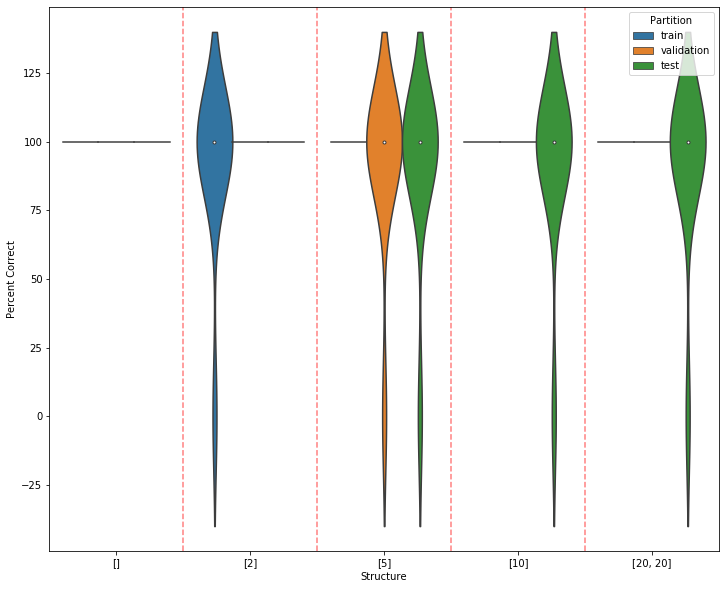

In [170]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)),device='gpu')
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)
nnet.training_time

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Epoch 100 LL train 0.6878 val 0.6672
Epoch 200 LL train 0.7895 val 0.7600
Epoch 300 LL train 0.8357 val 0.7884
Epoch 400 LL train 0.8626 val 0.7942
Epoch 500 LL train 0.8829 val 0.7969
Epoch 600 LL train 0.9015 val 0.8014
Epoch 700 LL train 0.9181 val 0.8058
Epoch 800 LL train 0.9320 val 0.8065
Epoch 900 LL train 0.9435 val 0.8044
Epoch 1000 LL train 0.9528 val 0.8007


1.1370391845703125

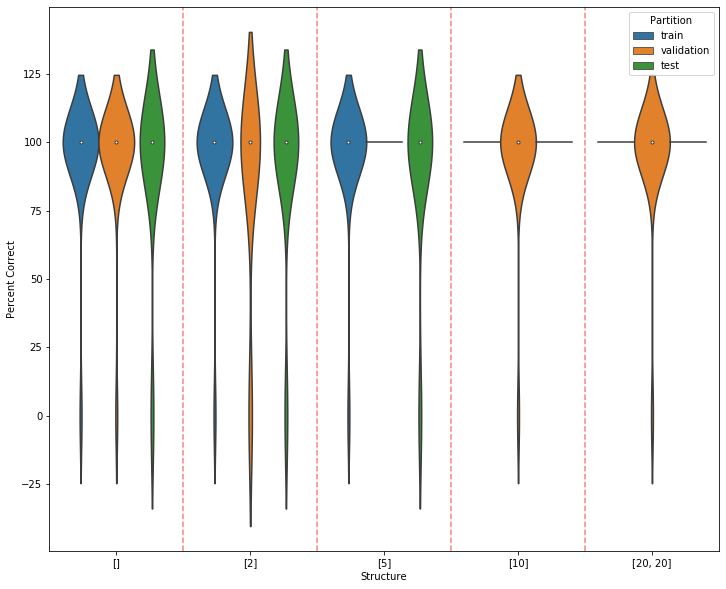

In [194]:
fractions = (0.6, 0.2, 0.2,0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 1000
learning_rate = 0.001

n_partitions = 20

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)),device='gpu')
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)
nnet.training_time

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 
Epoch 50 LL train 0.5844 val 0.5807
Epoch 100 LL train 0.6826 val 0.6792
Epoch 150 LL train 0.7409 val 0.7400
Epoch 200 LL train 0.7766 val 0.7732
Epoch 250 LL train 0.8018 val 0.7913
Epoch 300 LL train 0.8208 val 0.8019
Epoch 350 LL train 0.8358 val 0.8088
Epoch 400 LL train 0.8480 val 0.8138
Epoch 450 LL train 0.8585 val 0.8180
Epoch 500 LL train 0.8679 val 0.8216


0.5260651111602783

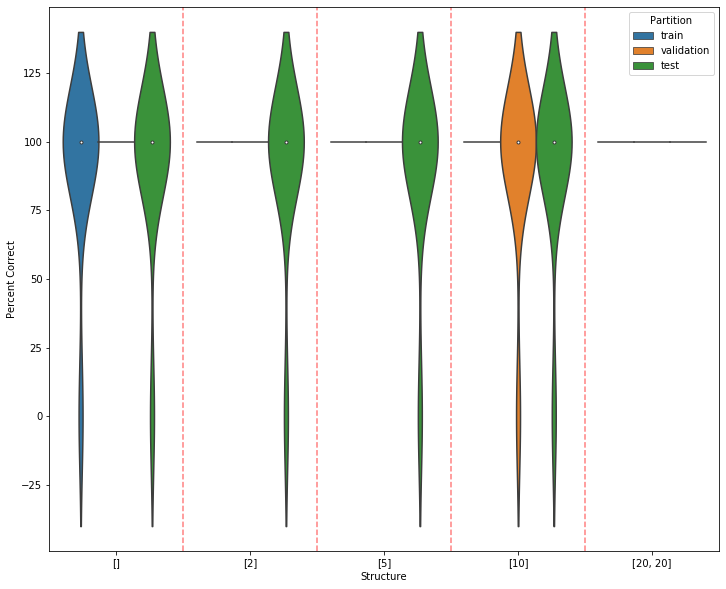

In [195]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.001

n_partitions = 10

results = []
for nh in n_hiddens_list:
    #results=results + (multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
results = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent Correct'))

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent Correct', hue='Partition', data=results)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)),device='gpu')
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)
nnet.training_time

From the trainnig time, we can infer that without using gpu the training time is more than 150 seconds whereas with the help of gpu it was lesser than 55 seconds. From this, we can conclude that running a convalutional layers tend to be more challenging especially when cases like kernel size and stride are small. This is because Covulutional Neural Network  requires alot of matrix calculations which would be complicated while using cpu. Thus,matrix calculations on a gpu would really decreases the training time of a Covutional neural network.